# 102flowers Classification Challenge

This dataset contains flower images of 102 categories. Training images are 6552, validation images are 818 and test images are 819.

## Importing libraries

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code.

In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import os
import copy
import time
import matplotlib.pyplot as plt
%matplotlib inline

from training import imshow, visualize_model, train_model
from sampler import ImbalancedDatasetSampler

In [2]:
from collections import OrderedDict

In [3]:
print("Pytorch Version : ",torch.__version__)
print("Torchvision Version : ",torchvision.__version__)
print("Is CUDA Available : ",torch.cuda.is_available())

Pytorch Version :  1.0.0.dev20190101
Torchvision Version :  0.2.1
Is CUDA Available :  True


In [4]:
#define the parameters
data_dir = "./data"
num_classes = 102
epochs = 20
batch_size = 32

In [5]:
torch.cuda.empty_cache()

## Load the dataset

Here you'll use torchvision to load the data. The data should be included alongside this notebook, otherwise you can download i. The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [6]:
#data augumentation and normalization
data_transforms = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
def sampler_for_train(dataset, phase='train'):
    if phase=="train":
        return torch.utils.data.DataLoader(dataset, sampler=ImbalancedDatasetSampler(dataset),
                                           batch_size=batch_size, num_workers=4)
    else:
        return torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size, shuffle=True, num_workers=4)
        
    
    

In [8]:
images_dataset = {x:datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) 
                         for x in ["train","valid","test"]}

dataloaders = {x: sampler_for_train(images_dataset[x], x) for x in ["train","valid","test"]}

dataset_sizes = {x:len(images_dataset[x]) for x in ["train","valid","test"]}

device = ("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class_names = images_dataset['train'].classes

In [10]:
print("Training DataSize : {}".format(dataset_sizes['train']))
print("Validation DataSize : {}".format(dataset_sizes['valid']))
print("Testing DataSize : {}".format(dataset_sizes['test']))
print("Device : {}".format(device))

Training DataSize : 6552
Validation DataSize : 818
Testing DataSize : 819
Device : cuda:0


## Label Mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file cat_to_name.json. It's a JSON object which you can read in with the json module. This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [19]:
import json

with open("./cat_to_name.json","r") as f:
    cat_to_name = json.load(f)

In [20]:
# changing categories to their actual names 
for i in range(0,len(class_names)):
    class_names[i] = cat_to_name.get(class_names[i])

## Visualize images

Let’s visualize a few training images so as to understand the data augmentations.

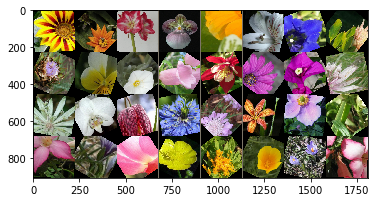

In [13]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

- 102 category dataset, consisting of 102 flower categories.
- Each class consists of between 40 and 258 images.
- This clearly demonstrates the data is imbalanced and the data need to be balanced in order to get the best results ( we are using sampler method above)

## Building and training the Classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from torchvision.models to get the image features. Build and train a new feed-forward classifier using those features.

- Load a pre-trained network (If you need a starting point, the VGG networks work great and are straightforward to use)
- Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
- Train the classifier layers using backpropagation using the pre-trained network to get the features
- Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Finetuning the convnet

Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

In [14]:
model_ft = models.densenet121(pretrained=True)

In [15]:
model_ft

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [16]:
for param in model_ft.parameters():
    param.requires_grad = True

In [17]:
#classifier for densenet121
#Load a pretrained model and reset final fully connected layer.

model_ft.classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(in_features=1024, out_features=512)),
    ('relu1',nn.ReLU()),
    ('dropout1',nn.Dropout(0.2)),
    ('fc2',nn.Linear(in_features=512, out_features=102)),
    ('output',nn.LogSoftmax(dim=1))
]))

In [18]:
model_ft.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [20]:
#define the loss and optimizer
criterion = nn.NLLLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

### Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

Train and evaluate.

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, exp_lr_scheduler, dataset_sizes, num_epochs=epochs)

Epoch 0/19
----------
train Loss: 2.8797 Acc: 0.2958
valid Loss: 1.8213 Acc: 0.4927
=> Saving a new best

Epoch 1/19
----------
train Loss: 1.6085 Acc: 0.5609
valid Loss: 0.9713 Acc: 0.7164
=> Saving a new best

Epoch 2/19
----------
train Loss: 1.1896 Acc: 0.6687
valid Loss: 0.8628 Acc: 0.7531
=> Saving a new best

Epoch 3/19
----------
train Loss: 0.7574 Acc: 0.7885
valid Loss: 0.3658 Acc: 0.8973
=> Saving a new best

Epoch 4/19
----------
train Loss: 0.5856 Acc: 0.8446
valid Loss: 0.3228 Acc: 0.9205
=> Saving a new best

Epoch 5/19
----------
train Loss: 0.5471 Acc: 0.8471
valid Loss: 0.2705 Acc: 0.9218
=> Saving a new best

Epoch 6/19
----------
train Loss: 0.4748 Acc: 0.8723
valid Loss: 0.2629 Acc: 0.9267
=> Saving a new best

Epoch 7/19
----------
train Loss: 0.4598 Acc: 0.8727
valid Loss: 0.2572 Acc: 0.9279
=> Saving a new best

Epoch 8/19
----------
train Loss: 0.4503 Acc: 0.8785
valid Loss: 0.2553 Acc: 0.9315
=> Saving a new best

Epoch 9/19
----------
train Loss: 0.4618 Acc: 

## Load the best model

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [2]:
from collections import OrderedDict
import torch
import torch.nn as nn
from torchvision import models

def load_checkpoint(checkpoint_path):
    model = models.densenet121(pretrained=True)
    classifier = nn.Sequential(OrderedDict([
                ('fc1',nn.Linear(in_features=1024, out_features=512)),
                ('relu1',nn.ReLU()),
                ('dropout1',nn.Dropout(0.2)),
                ('fc2',nn.Linear(in_features=512, out_features=102)),
                ('output',nn.LogSoftmax(dim=1))
            ]))
    
    model.classifier = classifier
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["state_dict"], strict=False)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    return model

In [4]:
model_final = load_checkpoint('./checkpoint_densenet152_2.pth.tar')

/anaconda3/envs/deeplearning/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


## Testing the model

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [28]:
from prediction import cal_accuracy

In [29]:
cal_accuracy(model_final, dataloaders, dataset_sizes, 'test')

Test Accuracy : 0.9316


## Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called predict that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

In [5]:
from PIL import Image

In [7]:
def process_image(image):
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor

In [58]:
img = ('./test/rose.jpg')
img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


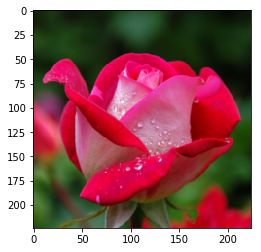

In [59]:
#check out the image
imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using class_to_idx which hopefully you added to the model or from an ImageFolder you used to load the data. Make sure to invert the dictionary so you get a mapping from index to class as well.

In [16]:
import torch.nn.functional as F

In [13]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cpu'

In [17]:
def predict(image_path, model, topk=5):   
    model.to(device)
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.to(device))
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [60]:
img = ('./test/rose.jpg')
val1, val2 = predict(img, model_final)
print(val1)
print(val2)

tensor([[0.9665, 0.0216, 0.0052, 0.0032, 0.0013]])
tensor([[74, 89, 78, 54, 36]])


## Sanity Check

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

In [63]:
def check_sanity():
    index = 74
    path = './test/rose.jpg'

    probabilities = predict(path, model_final)
    image = process_image(path)
    probabilities = probabilities
    

    imshow(image, cat_to_name[str(index)])
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)

    plt.show()

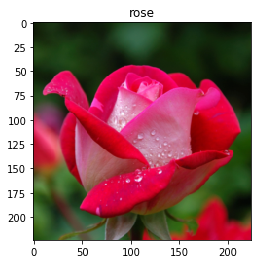

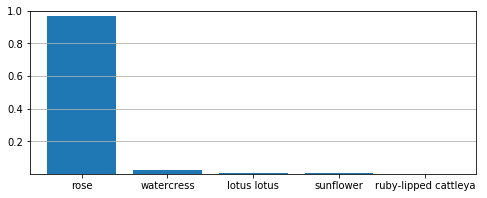

In [64]:
check_sanity()